In [1]:
# Auto checkpoint setup
import os
os.makedirs('checkpoints', exist_ok=True)
print('Checkpoint root:', os.path.abspath('checkpoints'))


Checkpoint root: /kaggle/working/checkpoints


In [ ]:

# Saving helpers for Kaggle working directory
import os, pickle

def save_model_artifacts_torch(model, optimizer=None, final_epoch=None):
    os.makedirs('/kaggle/working', exist_ok=True)
    model_name = model.__class__.__name__
    # Save state dict
    state_path_work = f'/kaggle/working/{model_name}_final_state.pt'
    torch.save({'epoch': final_epoch, 'model': model.state_dict(),
                'optimizer': optimizer.state_dict() if optimizer is not None else None},
               state_path_work)
    # Mirror in current dir for easy download
    torch.save({'epoch': final_epoch, 'model': model.state_dict(),
                'optimizer': optimizer.state_dict() if optimizer is not None else None},
               f'{model_name}_final_state.pt')
    # Save full model pickle
    was_cuda = next(model.parameters()).is_cuda if any(True for _ in model.parameters()) else False
    if was_cuda:
        model_cpu = copy.deepcopy(model).cpu()
    else:
        model_cpu = model
    with open(f'/kaggle/working/{model_name}.pkl', 'wb') as f:
        pickle.dump(model_cpu, f)
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model_cpu, f)
    print(f'Saved final artifacts for {model_name} to /kaggle/working and current directory')

def save_model_artifacts_generic(model, name_hint='model'):
    # Use joblib if available else pickle
    try:
        import joblib
        dumper = lambda obj, path: joblib.dump(obj, path)
    except Exception:
        import pickle
        dumper = lambda obj, path: open(path, 'wb').write(pickle.dumps(obj))
    os.makedirs('/kaggle/working', exist_ok=True)
    base = name_hint or model.__class__.__name__
    pkl1 = f'/kaggle/working/{base}.pkl'
    pkl2 = f'{base}.pkl'
    dumper(model, pkl1)
    dumper(model, pkl2)
    print(f'Saved {base} to {pkl1} and {pkl2}')


Import libraries

In [2]:
# === General Setup ===
import os
import gc
import random
import math
import time
import warnings
warnings.filterwarnings("ignore")

# === Data Handling ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning / Baselines ===
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb  # for baseline boosting model

# === Deep Learning (PyTorch) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === Reproducibility ===
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# === Check GPU ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Data cleaning and fetching

In [3]:
# === Mount Google Drive ===
#from google.colab import drive
#drive.mount('/content/drive')

# === Set file path ===
data_path = '/kaggle/input/gq-implied-volatility-forecasting/train/ETH.csv'

# === Load ETH.csv ===
import pandas as pd

df = pd.read_csv(data_path)

# === Display basic info ===
print("✅ File loaded successfully.\n")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMemory Usage:")
print(df.info(memory_usage='deep'))

# === Preview first few rows ===
df.head()


✅ File loaded successfully.

Shape: (631292, 23)

Columns:
 ['timestamp', 'mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5', 'ask_volume5', 'label']

Data Types:
 timestamp       object
mid_price      float64
bid_price1     float64
bid_volume1    float64
bid_price2     float64
bid_volume2    float64
bid_price3     float64
bid_volume3    float64
bid_price4     float64
bid_volume4    float64
bid_price5     float64
bid_volume5    float64
ask_price1     float64
ask_volume1    float64
ask_price2     float64
ask_volume2    float64
ask_price3     float64
ask_volume3    float64
ask_price4     float64
ask_volume4    float64
ask_price5     float64
ask_volume5    float64
label          float64
dtype: object

Memory Usage:
<class 'pandas.core.frame.DataFrame'>
Rang

,timestamp,mid_price,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,...,ask_volume1,ask_price2,ask_volume2,ask_price3,ask_volume3,ask_price4,ask_volume4,ask_price5,ask_volume5,label
0,2024-09-25 18:13:28,2581.605,2581.60,2980.3,2581.59,44.8,2581.56,139.1,2581.54,86.3,...,339.0,2581.67,9.2,2581.69,0.2,2581.70,23.4,2581.71,1.2,0.000060
1,2024-09-25 18:13:29,2581.285,2581.28,1400.6,2581.22,7.8,2581.19,5.0,2581.18,67.1,...,807.2,2581.30,144.4,2581.31,32.0,2581.32,151.0,2581.33,67.1,0.000057
2,2024-09-25 18:13:30,2581.285,2581.28,875.2,2581.22,7.8,2581.20,64.2,2581.19,5.0,...,807.5,2581.30,144.4,2581.31,32.0,2581.32,151.0,2581.33,52.0,0.000080
3,2024-09-25 18:13:31,2581.105,2581.10,1980.0,2581.09,508.4,2581.08,0.2,2581.05,18.7,...,833.3,2581.15,171.1,2581.20,60.7,2581.29,123.5,2581.30,104.0,0.000087
4,2024-09-25 18:13:32,2581.105,2581.10,1995.5,2581.09,508.4,2581.08,0.2,2581.05,18.7,...,717.3,2581.15,132.0,2581.20,60.7,2581.29,69.2,2581.30,242.9,0.000090


Timestamp check

In [4]:
# === Step 2.2: Timestamp Sanity Checks ===

# 1. Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# 2. Check if timestamps are sorted
is_sorted = df['timestamp'].is_monotonic_increasing
print("✅ Timestamps sorted chronologically?" , is_sorted)

# 3. Check for duplicate timestamps
duplicate_count = df['timestamp'].duplicated().sum()
print("🔁 Duplicate timestamps found:", duplicate_count)

# 4. Check for missing seconds
expected_range = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='1S')
missing_timestamps = expected_range.difference(df['timestamp'])
print("⏳ Missing timestamps (1-second gaps):", len(missing_timestamps))

# 5. Log time range
print("\n🕒 Time Range Summary:")
print("Start:", df['timestamp'].min())
print("End  :", df['timestamp'].max())
print("Expected Rows:", len(expected_range))
print("Actual Rows  :", len(df))


✅ Timestamps sorted chronologically? True
🔁 Duplicate timestamps found: 0
⏳ Missing timestamps (1-second gaps): 0

🕒 Time Range Summary:
Start: 2024-09-25 18:13:28+00:00
End  : 2024-10-03 01:34:59+00:00
Expected Rows: 631292
Actual Rows  : 631292


Orderbook validity check

In [5]:
# === Step 2.3: Order Book Ladder Validity ===

# 1. Check bid price order: bid_price1 ≥ bid_price2 ≥ ... ≥ bid_price5
bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
bid_order_violations = (df[bid_price_cols].diff(axis=1).iloc[:, 1:] > 0).any(axis=1)
print("🔻 Bid price order violations:", bid_order_violations.sum())

# 2. Check ask price order: ask_price1 ≤ ask_price2 ≤ ... ≤ ask_price5
ask_price_cols = ['ask_price1', 'ask_price2', 'ask_price3', 'ask_price4', 'ask_price5']
ask_order_violations = (df[ask_price_cols].diff(axis=1).iloc[:, 1:] < 0).any(axis=1)
print("🔺 Ask price order violations:", ask_order_violations.sum())

# 3. Check locked and crossed books
locked_books = (df['ask_price1'] == df['bid_price1'])
crossed_books = (df['ask_price1'] < df['bid_price1'])
print("🔒 Locked book rows:", locked_books.sum())
print("❌ Crossed book rows:", crossed_books.sum())

# 4. Check for negative volumes
volume_cols = [col for col in df.columns if 'volume' in col]
negative_volumes = (df[volume_cols] < 0).any(axis=1)
print("🚫 Rows with negative volume:", negative_volumes.sum())

# (Optional) Count rows with 0 at best bid/ask volumes
zero_best_vol = ((df['bid_volume1'] == 0) | (df['ask_volume1'] == 0))
print("⚠️ Rows with zero volume at best bid/ask:", zero_best_vol.sum())


🔻 Bid price order violations: 1
🔺 Ask price order violations: 1
🔒 Locked book rows: 0
❌ Crossed book rows: 0
🚫 Rows with negative volume: 1
⚠️ Rows with zero volume at best bid/ask: 0


Mid price and spread checks

In [6]:
# === Step 2.4: Mid-Price and Spread Consistency Checks ===

# 1. Compute expected mid-price
df['mid_expected'] = (df['bid_price1'] + df['ask_price1']) / 2

# 2. Calculate absolute and relative error from reported mid_price
df['mid_abs_error'] = np.abs(df['mid_price'] - df['mid_expected'])
df['mid_rel_error'] = df['mid_abs_error'] / df['mid_expected']

# 3. Define mid-price error threshold (tick size ~ $0.01 or $0.02)
mid_error_threshold = 0.02
mid_error_violations = df['mid_abs_error'] > mid_error_threshold
print(f"🧮 Mid-price deviation > {mid_error_threshold}: {mid_error_violations.sum()} rows")

# 4. Compute spread and relative spread
df['spread'] = df['ask_price1'] - df['bid_price1']
df['rel_spread'] = df['spread'] / df['mid_expected']

# 5. Describe spread stats
print("\n📊 Spread Summary Stats:")
print(df['spread'].describe())
print("\n📊 Relative Spread Summary Stats:")
print(df['rel_spread'].describe())

# 6. Identify extreme spreads (e.g., top 0.1% outliers)
spread_threshold = df['spread'].quantile(0.999)
extreme_spread_rows = df['spread'] > spread_threshold
print(f"🚨 Extreme spreads > {spread_threshold:.4f}: {extreme_spread_rows.sum()} rows")

# 7. Save key error columns for later filtering
cols_to_keep = ['timestamp', 'mid_price', 'mid_expected', 'mid_abs_error', 'spread', 'rel_spread']
df_check = df[cols_to_keep].copy()


🧮 Mid-price deviation > 0.02: 1 rows

📊 Spread Summary Stats:
count    5.958620e+05
mean     8.375769e+33
std      6.465432e+36
min      1.000000e-02
25%      1.000000e-02
50%      1.000000e-02
75%      1.000000e-02
max      4.990803e+39
Name: spread, dtype: float64

📊 Relative Spread Summary Stats:
count    595862.000000
mean          0.000007
std           0.002591
min           0.000004
25%           0.000004
50%           0.000004
75%           0.000004
max           2.000000
Name: rel_spread, dtype: float64
🚨 Extreme spreads > 0.0200: 515 rows


Depth and imbalance checks


📊 Imbalance Summary Stats:
count    595862.000000
mean         -0.000797
std           0.601713
min          -1.000000
25%          -0.528699
50%          -0.002169
75%           0.528057
max           0.999803
Name: imbalance, dtype: float64


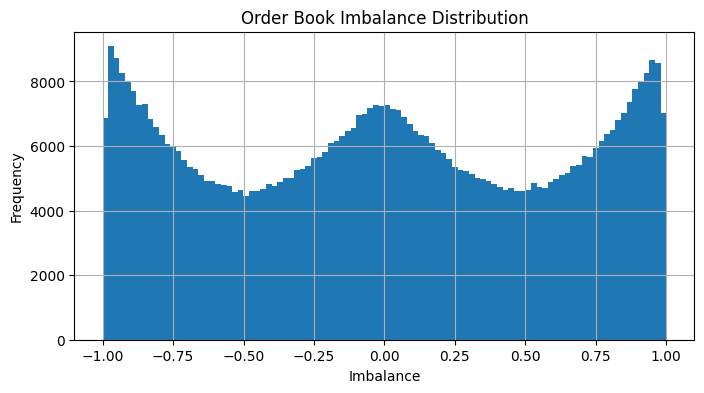


❗ Zero total depth (bid or ask): 35430
❗ Imbalance = ±1 (fully one-sided books): 1


In [7]:
# === Step 2.5: Depth and Imbalance Checks ===

# 1. Compute total depth on each side
df['bid_depth'] = df[[f'bid_volume{i}' for i in range(1, 6)]].sum(axis=1)
df['ask_depth'] = df[[f'ask_volume{i}' for i in range(1, 6)]].sum(axis=1)

# 2. Compute imbalance: (bid - ask) / (bid + ask)
df['imbalance'] = (df['bid_depth'] - df['ask_depth']) / (df['bid_depth'] + df['ask_depth'])

# 3. Basic stats on imbalance
print("\n📊 Imbalance Summary Stats:")
print(df['imbalance'].describe())

# 4. Plot imbalance distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
df['imbalance'].hist(bins=100)
plt.title("Order Book Imbalance Distribution")
plt.xlabel("Imbalance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 5. Detect anomalies
zero_depth_rows = ((df['bid_depth'] == 0) | (df['ask_depth'] == 0))
extreme_imbalance_rows = df['imbalance'].abs() == 1

print("\n❗ Zero total depth (bid or ask):", zero_depth_rows.sum())
print("❗ Imbalance = ±1 (fully one-sided books):", extreme_imbalance_rows.sum())


Microstructure Activity analysis

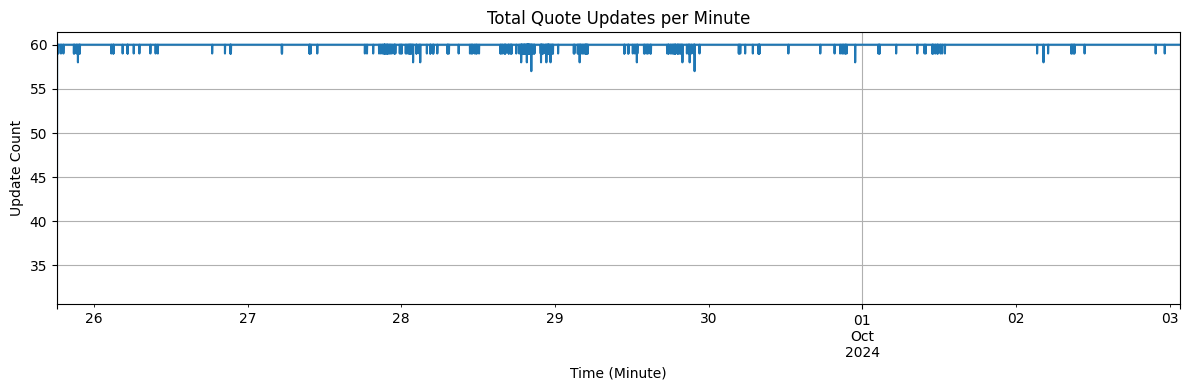


📊 Quote Update Summary:
Total rows: 631292
Rows with price update: 259243
Rows with volume-only update: 371759


In [8]:
# === Step 2.6: Microstructure Activity Analysis ===

# 1. Identify price changes at top of book
df['bid_price1_change'] = df['bid_price1'].diff() != 0
df['ask_price1_change'] = df['ask_price1'].diff() != 0
df['price_update'] = df['bid_price1_change'] | df['ask_price1_change']

# 2. Identify volume-only changes (price same but volume changed)
df['bid_volume1_change'] = df['bid_volume1'].diff() != 0
df['ask_volume1_change'] = df['ask_volume1'].diff() != 0
df['volume_only_update'] = ~df['price_update'] & (df['bid_volume1_change'] | df['ask_volume1_change'])

# 3. Group by minute and count updates
df['minute'] = df['timestamp'].dt.floor('min')
activity_per_min = df.groupby('minute').agg({
    'price_update': 'sum',
    'volume_only_update': 'sum'
}).rename(columns={
    'price_update': 'price_updates_per_min',
    'volume_only_update': 'volume_only_updates_per_min'
})
activity_per_min['total_updates'] = activity_per_min.sum(axis=1)

# 4. Plot total update rate over time
plt.figure(figsize=(12,4))
activity_per_min['total_updates'].plot()
plt.title("Total Quote Updates per Minute")
plt.xlabel("Time (Minute)")
plt.ylabel("Update Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Summary
print("\n📊 Quote Update Summary:")
print("Total rows:", len(df))
print("Rows with price update:", df['price_update'].sum())
print("Rows with volume-only update:", df['volume_only_update'].sum())


Return and volatility analysis

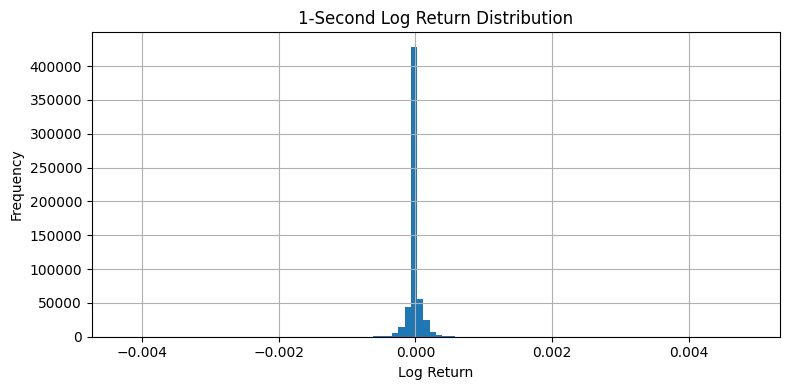

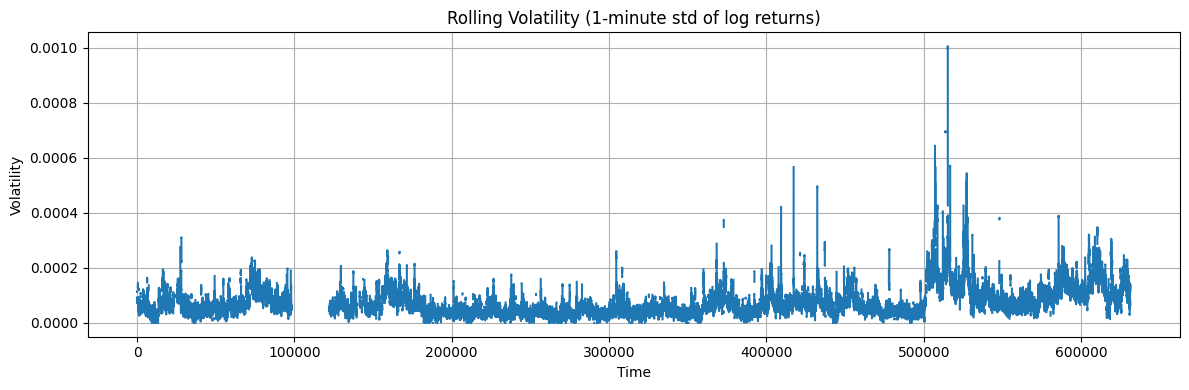

In [9]:
import numpy as np

# 1. Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. Sort (safety check)
df = df.sort_values('timestamp')

# 3. Calculate log returns using mid_price
df['log_return'] = np.log(df['mid_price']) - np.log(df['mid_price'].shift(1))

# 4. Plot return histogram
plt.figure(figsize=(8,4))
df['log_return'].dropna().hist(bins=100)
plt.title("1-Second Log Return Distribution")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Calculate rolling volatility (1-minute window = 60s)
df['rolling_volatility'] = df['log_return'].rolling(window=60).std()

# 6. Plot rolling volatility
plt.figure(figsize=(12,4))
df['rolling_volatility'].plot()
plt.title("Rolling Volatility (1-minute std of log returns)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()


Train test split

In [10]:
import pandas as pd

# Define paths
train_path = "/kaggle/input/gq-implied-volatility-forecasting/train/ETH.csv"
test_path = "/kaggle/input/gq-implied-volatility-forecasting/test/ETH.csv"

# Load both files
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Print confirmation
print("✅ Files loaded successfully!\n")

print("📘 Training File: ETH.csv")
print(f"➡ Shape: {df_train.shape}\n")

print("📗 Test File: ETH (1).csv")
print(f"➡ Shape: {df_test.shape}")


✅ Files loaded successfully!

📘 Training File: ETH.csv
➡ Shape: (631292, 23)

📗 Test File: ETH (1).csv
➡ Shape: (270548, 22)


Label checks and feature normalisation

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 3.2 — Check for proper label alignment
print("\n🔍 Verifying label alignment with mid_price shift...")

df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

# Check time difference between rows
row_time_diffs = df_train['timestamp'].diff().value_counts()
print("🕒 Unique time gaps between rows (expected: 1s):")
print(row_time_diffs.head())

# Inspect if label corresponds to mid_price 10 seconds ahead
# We'll shift mid_price by -10 steps (10s forward)
df_train['mid_price_t+10'] = df_train['mid_price'].shift(-10)
df_train['label_diff'] = np.abs(df_train['mid_price_t+10'] - df_train['label'])

print("\n📏 Label vs. mid_price_t+10 diff stats:")
print(df_train['label_diff'].describe())

# Optional: Display a few sample rows to verify visually
print("\n🔍 Sample rows with label vs mid_price_t+10:")
print(df_train[['mid_price', 'mid_price_t+10', 'label', 'label_diff']].head(15))

# Step 3.3 — Drop rows with NaNs
print("\n🧹 Dropping rows with any missing values...")
before_drop = df_train.shape[0]
df_train.dropna(inplace=True)
after_drop = df_train.shape[0]
print(f"✅ Dropped {before_drop - after_drop} rows (remaining: {after_drop})")

# Step 3.4 — Normalize features for GRU/LSTM
print("\n⚙️ Standardizing features...")

# Define feature columns (excluding timestamp, label, and any engineered columns)
feature_cols = [col for col in df_train.columns
                if col not in ['timestamp', 'label', 'mid_price_t+10', 'label_diff']]

scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

print("✅ Features normalized successfully.")



🔍 Verifying label alignment with mid_price shift...
🕒 Unique time gaps between rows (expected: 1s):
timestamp
0 days 00:00:01    631291
Name: count, dtype: int64

📏 Label vs. mid_price_t+10 diff stats:
count    5.957410e+05
mean     4.188735e+33
std      3.233044e+36
min      2.352225e+03
25%      2.582815e+03
50%      2.635145e+03
75%      2.664755e+03
max      2.495401e+39
Name: label_diff, dtype: float64

🔍 Sample rows with label vs mid_price_t+10:
    mid_price  mid_price_t+10     label   label_diff
0    2581.605        2581.455  0.000060  2581.454940
1    2581.285        2582.045  0.000057  2582.044943
2    2581.285        2581.835  0.000080  2581.834920
3    2581.105        2581.605  0.000087  2581.604913
4    2581.105        2581.505  0.000090  2581.504910
5    2581.275        2581.505  0.000091  2581.504909
6    2581.275        2581.505  0.000090  2581.504910
7    2581.455        2581.455  0.000090  2581.454910
8    2581.455        2581.445  0.000087  2581.444913
9    2581.455

Evaluation metric functions

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(y_true, y_pred):
    """
    Computes key regression evaluation metrics.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # Optional: Directional accuracy
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    directional_accuracy = np.mean(direction_true == direction_pred) * 100

    print(f"📊 Evaluation Metrics:")
    print(f"🔹 MSE  : {mse:.6f}")
    print(f"🔹 RMSE : {rmse:.6f}")
    print(f"🔹 MAE  : {mae:.6f}")
    print(f"🔹 Directional Accuracy: {directional_accuracy:.2f}%")

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "directional_accuracy": directional_accuracy
    }


Feature engineering - helper functions

In [13]:
import numpy as np
import pandas as pd

#Utility helpers

def _safe_div(a, b):
    """Elementwise safe division."""
    return np.where(b != 0, a / b, 0.0)

def _log_return(x, lag=1):
    """Compute log return with lag (NumPy arrays only)."""
    x = np.asarray(x, dtype=float)
    prev = np.roll(x, lag)
    out = np.zeros_like(x, dtype=float)
    mask = (prev > 0) & (x > 0)
    out[mask] = np.log(x[mask]) - np.log(prev[mask])
    out[~mask] = 0.0
    out[:lag] = 0.0
    return out

def _rolling_count_events(series, window):
    """Count boolean events in the past window using cumulative sum trick."""
    s = series.astype(int)
    c = s.cumsum()
    out = c - c.shift(window, fill_value=0)
    return out

def _add_time_cyclical(df, ts_col="timestamp"):
    """Add second-of-day sine cos and weekday features to DataFrame."""
    dt = pd.to_datetime(df[ts_col])
    sod = dt.dt.hour * 3600 + dt.dt.minute * 60 + dt.dt.second
    w = dt.dt.weekday
    df["sod_sin"] = np.sin(2 * np.pi * sod / 86400.0)
    df["sod_cos"] = np.cos(2 * np.pi * sod / 86400.0)
    df["weekday"] = w.astype(int)
    return df

#Core feature builders

def add_top_of_book_features(df):
    """Adds core top-of-book price and volume features."""

    # Parse and cast required columns
    bid = df["bid_price1"].astype(float)
    ask = df["ask_price1"].astype(float)
    bvol = df["bid_volume1"].astype(float)
    avol = df["ask_volume1"].astype(float)

    # Mid-price and spread
    df["mid"] = (bid + ask) * 0.5
    df["spread"] = ask - bid
    df["rel_spread_bp"] = _safe_div(df["spread"], df["mid"]) * 1e4  # basis points

    # Microprice = size-weighted mid
    denom = bvol + avol
    df["microprice"] = _safe_div(ask * bvol + bid * avol, denom)

    # Log returns (lags)
    for lag in [1, 2, 3, 5, 10, 30, 60]:
        df[f"ret_mid_lag{lag}"] = _log_return(df["mid"].values, lag=lag)
        df[f"ret_micro_lag{lag}"] = _log_return(df["microprice"].values, lag=lag)

    # Binary flags for quote updates
    df["chg_bid_px1"] = (bid.diff().fillna(0) != 0).astype(int)
    df["chg_ask_px1"] = (ask.diff().fillna(0) != 0).astype(int)

    # Rolling count of quote updates
    for w in [10, 30, 60, 120, 300]:
        df[f"cnt_bid_px1_chg_{w}s"] = _rolling_count_events(df["chg_bid_px1"], w)
        df[f"cnt_ask_px1_chg_{w}s"] = _rolling_count_events(df["chg_ask_px1"], w)

    return df

def add_depth_and_imbalance_features(df, levels=5):
    """Adds market depth features and volume/price imbalance features."""

    # Construct column lists
    bid_vol_cols = [f"bid_volume{i}" for i in range(1, levels + 1)]
    ask_vol_cols = [f"ask_volume{i}" for i in range(1, levels + 1)]
    bid_px_cols = [f"bid_price{i}" for i in range(1, levels + 1)]
    ask_px_cols = [f"ask_price{i}" for i in range(1, levels + 1)]

    # Cast to float
    bv = df[bid_vol_cols].astype(float)
    av = df[ask_vol_cols].astype(float)

    # Total depth & imbalance
    df["depth_bid"] = bv.sum(axis=1)
    df["depth_ask"] = av.sum(axis=1)
    df["depth_total"] = df["depth_bid"] + df["depth_ask"]
    df["imbalance_lvl1"] = _safe_div(df["bid_volume1"] - df["ask_volume1"], df["bid_volume1"] + df["ask_volume1"])
    df["imbalance_total"] = _safe_div(df["depth_bid"] - df["depth_ask"], df["depth_total"])

    # Depth-weighted average prices (WAP)
    bp = df[bid_px_cols].astype(float).values
    ap = df[ask_px_cols].astype(float).values
    bv_np = bv.values
    av_np = av.values

    bid_wap = _safe_div((bp * bv_np).sum(axis=1), bv_np.sum(axis=1))
    ask_wap = _safe_div((ap * av_np).sum(axis=1), av_np.sum(axis=1))

    df["bid_wap"] = bid_wap
    df["ask_wap"] = ask_wap
    df["wap_spread"] = ask_wap - bid_wap
    df["wap_mid"] = 0.5 * (ask_wap + bid_wap)

    return df

def add_volatility_proxies(df):
    """Adds realized variance, volatility, and bipower variation from mid-price returns."""

    r = pd.Series(_log_return(df["mid"].values, lag=1)).astype(float)
    r.name = "r1"

    # Realized variance and volatility
    for w in [10, 30, 60, 120, 300]:
        rv = r.pow(2).rolling(w).sum()
        df[f"rv_{w}s"] = rv.values
        df[f"rvol_{w}s"] = np.sqrt(np.maximum(rv.values, 0.0))

    # Bipower variation
    abs_r = r.abs()
    for w in [10, 30, 60, 120, 300]:
        bp = (abs_r.shift(1) * abs_r).rolling(w).sum() * (np.pi / 2.0)
        df[f"bpv_{w}s"] = bp.values

    return df

def add_order_flow_features(df):
    """Adds Order Flow Imbalance (OFI) and its rolling statistics."""

    bp = df["bid_price1"].astype(float).values
    ap = df["ask_price1"].astype(float).values
    bv = df["bid_volume1"].astype(float).values
    av = df["ask_volume1"].astype(float).values

    # Previous tick values
    bp_prev = np.roll(bp, 1); bp_prev[0] = bp[0]
    ap_prev = np.roll(ap, 1); ap_prev[0] = ap[0]
    bv_prev = np.roll(bv, 1); bv_prev[0] = bv[0]
    av_prev = np.roll(av, 1); av_prev[0] = av[0]

    # OFI computation
    ofi = np.zeros_like(bp, dtype=float)
    ofi += np.where(bp > bp_prev, bv, 0.0)
    ofi += np.where(bp < bp_prev, -bv_prev, 0.0)
    ofi += np.where(bp == bp_prev, bv - bv_prev, 0.0)
    ofi += np.where(ap < ap_prev, -av, 0.0)
    ofi += np.where(ap > ap_prev, av_prev, 0.0)
    ofi += np.where(ap == ap_prev, -(av - av_prev), 0.0)

    df["ofi_lvl1"] = ofi

    # Rolling stats
    for w in [10, 30, 60, 120, 300]:
        df[f"ofi_sum_{w}s"] = pd.Series(ofi).rolling(w).sum().values
        df[f"ofi_std_{w}s"] = pd.Series(ofi).rolling(w).std().fillna(0.0).values

    return df

def add_liquidity_flags(df):
    """Adds binary flags for wide spreads and shallow order book depth."""

    # Use expanding window to avoid lookahead bias
    spread_med = df["spread"].expanding().median()
    depth_q10 = df["depth_total"].expanding().quantile(0.10)

    df["flag_wide_spread"] = (df["spread"] > 3.0 * spread_med).astype(int)
    df["flag_shallow_depth"] = (df["depth_total"] < depth_q10).astype(int)

    return df

def add_cross_asset_features(eth_df, peer_df, peer_name="BTC"):
    """
    Merges peer asset data (e.g., BTC) and computes lagged returns and rolling correlation with ETH.
    """
    use_cols = ["timestamp", "mid"]
    peer = peer_df[use_cols].copy()
    peer.rename(columns={"mid": f"mid_{peer_name}"}, inplace=True)

    # Lagged returns for peer asset
    for lag in [1, 2, 3, 5, 10, 30, 60]:
        peer[f"ret_mid_{peer_name}_lag{lag}"] = _log_return(peer[f"mid_{peer_name}"].values, lag=lag)

    out = eth_df.merge(peer, on="timestamp", how="left")

    # Correlation between ETH and peer asset returns
    r_eth = pd.Series(_log_return(out["mid"].values, lag=1))
    r_peer = pd.Series(_log_return(out[f"mid_{peer_name}"].values, lag=1))

    for w in [60, 120, 300]:
        corr = r_eth.rolling(w).corr(r_peer)
        out[f"corr_eth_{peer_name}_{w}s"] = corr.values

    return out

def engineer_features_for_asset(df):
    """Applies the full feature engineering pipeline for one asset (e.g., ETH/NIFTY)."""
    df = df.copy()
    df.sort_values("timestamp", inplace=True)

    # Run all core feature functions
    _add_time_cyclical(df, "timestamp")
    add_top_of_book_features(df)
    add_depth_and_imbalance_features(df, levels=5)
    add_volatility_proxies(df)
    add_order_flow_features(df)
    add_liquidity_flags(df)

    # Prevent lookahead by shifting numeric features
    base_cols = set(df.columns)
    num_df = df.select_dtypes(include=[np.number])

    # Identify new numeric features
    new_cols = [c for c in num_df.columns if c not in base_cols or c in [
        "mid", "spread", "rel_spread_bp", "microprice",
        "depth_bid", "depth_ask", "depth_total",
        "imbalance_lvl1", "imbalance_total",
        "bid_wap", "ask_wap", "wap_spread", "wap_mid",
        "ofi_lvl1"
    ]]

    # Do not shift raw order book values
    raw_cols = [f"{side}_{typ}{i}" for i in range(1, 6) for side in ["bid", "ask"] for typ in ["price", "volume"]]
    shift_cols = [c for c in new_cols if c not in raw_cols]

    df[shift_cols] = df[shift_cols].shift(1)

    return df

def build_eth_with_peers(eth_df, peers_dict):
    """
    Run full ETH feature engineering and merge peer (e.g., BTC, VIX) features.
    peers_dict = {"BTC": btc_df, "VIX": vix_df, ...}
    """
    eth_feat = engineer_features_for_asset(eth_df)
    out = eth_feat

    for name, peer_df in peers_dict.items():
        peer_feat = engineer_features_for_asset(peer_df)[["timestamp", "mid"]].copy()
        out = add_cross_asset_features(out, peer_feat, peer_name=name)

    return out

def finalize_feature_table(df, label_col=None):
    """
    Final cleanup of feature table.
    - Drops rows with NaNs created by shift/rolling.
    - Retains the label column if specified.
    """
    keep_cols = [c for c in df.columns if c != label_col] + \
                ([label_col] if label_col and label_col in df.columns else [])

    df = df[keep_cols].copy()
    df = df.dropna().reset_index(drop=True)

    return df




In [14]:
import pandas as pd
import os

# Mount your Google Drive (if not done already)
#from google.colab import drive
#drive.mount('/content/drive')

# Define the correct paths inside your 'Goquant' folder
base_path = "/kaggle/input/gq-implied-volatility-forecasting"
eth_train_path = os.path.join(base_path, "train/ETH.csv")
eth_test_path = os.path.join(base_path, "test/ETH.csv")

# Load the CSVs
eth_train = pd.read_csv(eth_train_path)
eth_test = pd.read_csv(eth_test_path)

# Print basic schema info
print("🟢 ETH Train Info:")
print(eth_train.info(), "\n")

print("🟡 ETH Test Info:")
print(eth_test.info(), "\n")

# Check for column differences
print("📊 Columns in Train but not Test:", set(eth_train.columns) - set(eth_test.columns))
print("📊 Columns in Test but not Train:", set(eth_test.columns) - set(eth_train.columns))

# Check timestamp ranges
print("🕒 Train Timestamp Range:", eth_train['timestamp'].min(), "→", eth_train['timestamp'].max())
print("🕒 Test Timestamp Range:", eth_test['timestamp'].min(), "→", eth_test['timestamp'].max())

# Show a few sample rows
print("\n🔍 Sample Train Rows:")
print(eth_train.head(), "\n")
print("🔍 Sample Test Rows:")
print(eth_test.head())


🟢 ETH Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631292 entries, 0 to 631291
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    631292 non-null  object 
 1   mid_price    595862 non-null  float64
 2   bid_price1   595862 non-null  float64
 3   bid_volume1  595862 non-null  float64
 4   bid_price2   595862 non-null  float64
 5   bid_volume2  595862 non-null  float64
 6   bid_price3   595862 non-null  float64
 7   bid_volume3  595862 non-null  float64
 8   bid_price4   595862 non-null  float64
 9   bid_volume4  595862 non-null  float64
 10  bid_price5   595862 non-null  float64
 11  bid_volume5  595862 non-null  float64
 12  ask_price1   595862 non-null  float64
 13  ask_volume1  595862 non-null  float64
 14  ask_price2   595862 non-null  float64
 15  ask_volume2  595862 non-null  float64
 16  ask_price3   595862 non-null  float64
 17  ask_volume3  595862 non-null  float64
 18  ask_pr

Feature scaling

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# Define the correct paths inside your 'Goquant' folder
base_path = "/kaggle/input/gq-implied-volatility-forecasting"
eth_train_path = os.path.join(base_path, "train/ETH.csv")
eth_test_path = os.path.join(base_path, "test/ETH.csv")

# === STEP 2: Apply Feature Engineering ===
train_df = engineer_features_for_asset(eth_train)
test_df = engineer_features_for_asset(eth_test)

# === STEP 3: Finalize & Drop NaNs ===
train_df = finalize_feature_table(train_df, label_col="label")
test_df = finalize_feature_table(test_df)  # no label, so we don't specify it

# === STEP 4: Outlier Clipping (1st–99th percentile from train) ===
# Get numeric columns from train_df
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# Drop 'label' from numeric_cols for test_df if it's present
numeric_cols_without_label = numeric_cols.drop('label') if 'label' in numeric_cols else numeric_cols

# Compute 1st and 99th percentiles on train data
clip_bounds = train_df[numeric_cols].quantile([0.01, 0.99])

# Clip outliers on both train and test separately
train_df[numeric_cols] = train_df[numeric_cols].clip(lower=clip_bounds.loc[0.01], upper=clip_bounds.loc[0.99], axis=1)
test_df[numeric_cols_without_label] = test_df[numeric_cols_without_label].clip(
    lower=clip_bounds.loc[0.01, numeric_cols_without_label],
    upper=clip_bounds.loc[0.99, numeric_cols_without_label],
    axis=1
)


# === STEP 5: Standard Scaling ===
X_train = train_df.drop(columns=["timestamp", "label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["timestamp"])  # no label in test

# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for future use
joblib.dump(scaler, "/kaggle/working/scaler.pkl")

# Optional: Convert back to DataFrame for exploration
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✅ Step 5 complete.")
print("Train shape:", X_train_scaled.shape, "| Test shape:", X_test_scaled.shape)




✅ Step 5 complete.
Train shape: (585892, 91) | Test shape: (261239, 91)


In [16]:
from sklearn.preprocessing import StandardScaler

# Identify columns to scale: exclude 'timestamp' and 'label'
features_to_scale = [col for col in train_df.columns if col not in ['timestamp', 'label']]

# Initialize and fit scaler on train data
scaler = StandardScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

# Apply same scaling to test data
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])


Sequence Windowing

In [17]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# === CONFIGURATION ===
LOOKBACK = 180         # seconds of history
STRIDE = 1             # stride between windows
FUTURE_OFFSET = 10     # predict IV at t+10 seconds

# === Step 1: Utility functions ===
def _make_start_indices(n_rows, lookback, offset, stride=1):
    """
    Generate valid prediction indices t, such that:
    - We have enough past data: t >= lookback - 1
    - We have enough future target: t + offset < n_rows
    """
    start = lookback - 1
    end = n_rows - offset - 1
    if end < start:
        return np.empty(0, dtype=np.int64)
    return np.arange(start, end + 1, stride, dtype=np.int64)

class LOBWindowDataset(Dataset):
    """
    Memory-safe sliding window dataset for time series.
    """
    def __init__(self, features, labels, lookback, offset, stride=1):
        assert features.ndim == 2, "Features must be 2D [time, features]"
        assert features.dtype == np.float32, "Features must be float32 to save memory"

        self.X = features
        self.y = None if labels is None else np.asarray(labels, dtype=np.float32)
        self.L = int(lookback)
        self.O = int(offset)
        self.idxs = _make_start_indices(len(features), self.L, self.O, stride)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        t = self.idxs[i]
        x = self.X[t - self.L + 1 : t + 1]  # window of shape [L, F]
        if self.y is None:
            return torch.from_numpy(x)
        target = self.y[t + self.O]
        return torch.from_numpy(x), torch.tensor(target, dtype=torch.float32)

def build_datasets(train_df, test_df, label_col="label"):
    feat_cols = [col for col in train_df.columns if col not in ["timestamp", label_col]]

    # Ensure consistent columns
    assert set(feat_cols).issubset(set(test_df.columns)), "Test is missing some feature columns"

    X_train = train_df[feat_cols].to_numpy(dtype=np.float32, copy=False)
    y_train = train_df[label_col].to_numpy(dtype=np.float32, copy=False)

    X_test = test_df[feat_cols].to_numpy(dtype=np.float32, copy=False)

    train_ds = LOBWindowDataset(X_train, y_train, LOOKBACK, FUTURE_OFFSET, STRIDE)
    test_ds = LOBWindowDataset(X_test,LOOKBACK, FUTURE_OFFSET, STRIDE)  # USE IT

    return train_ds, test_ds, feat_cols # RETURN IT


# === Step 3: DataLoader builder ===
def build_loaders(train_ds, test_ds, batch_size=64):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
    return train_loader, test_loader

# === Step 4: Optional – recover timestamps for test prediction ===
def timestamps_for_submission(test_df, test_ds, future_offset=FUTURE_OFFSET):
    ts = np.asarray(test_df["timestamp"])
    pred_idx = test_ds.idxs + future_offset
    return ts[pred_idx]

# Build datasets and loaders
train_ds, test_ds, feat_cols = build_datasets(train_df, test_df)
train_loader, test_loader = build_loaders(train_ds, test_ds)

# (Optional) Check sample shapes
for xb, yb in train_loader:
    print("🧾 Input shape:", xb.shape)  # [B, 180, F]
    print("🎯 Target shape:", yb.shape) # [B]
    break

print("First input window:")
print(xb[0])         # [180, num_features]
print("First target IV:", yb[0].item())


🧾 Input shape: torch.Size([64, 180, 91])
🎯 Target shape: torch.Size([64])
First input window:
tensor([[-2.5261, -2.5261,  0.4109,  ...,  0.4230,  0.0000, -0.1772],
        [-2.5261, -2.5261, -0.4264,  ...,  0.4129,  0.0000,  5.6433],
        [-2.5269, -2.5269, -0.2486,  ...,  0.4192,  0.0000, -0.1772],
        ...,
        [-2.4803, -2.4803,  0.6308,  ...,  0.5108,  0.0000, -0.1772],
        [-2.4845, -2.4845, -0.8282,  ...,  0.5188,  0.0000, -0.1772],
        [-2.4845, -2.4845, -0.4471,  ...,  0.5151,  0.0000, -0.1772]])
First target IV: 0.00016755609249230474


Naive Baseline model

In [18]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(y_true, y_pred, label="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {label} Evaluation:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")

# === Step 7: Evaluate Naive Baseline without using y_test ===

print("📉 Evaluating Naive Baseline:")

true_vals = []
pred_vals = []

X_raw = test_ds.X          # shape: [T, F]
L = test_ds.L              # lookback = 180
O = test_ds.O              # future offset = 10
idxs = test_ds.idxs        # valid t indices
label_col = -1             # assume last column is IV

for t in tqdm(idxs, desc="Evaluating Naive Baseline"):
    # Extract window and future IV value from raw matrix
    window = X_raw[t - L + 1 : t + 1]         # shape: [180, F]
    last_iv_in_window = window[-1, label_col]
    future_iv = X_raw[t + O, label_col]       # true label at t + offset

    pred_vals.append(last_iv_in_window)
    true_vals.append(future_iv)

# Convert to np arrays
y_pred_naive = np.array(pred_vals)
y_true_naive = np.array(true_vals)

evaluate(y_true_naive, y_pred_naive, label="Naive Last-IV Baseline")


📉 Evaluating Naive Baseline:


Evaluating Naive Baseline: 100%|██████████| 261229/261229 [00:00<00:00, 800465.40it/s]


📊 Naive Last-IV Baseline Evaluation:
  MSE:  2.481460
  RMSE: 1.575265
  MAE:  0.426330
  R²:   0.026851


Autoregressive baseline

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- CONFIG ---
N = 10                         # number of past IV values to use
IV_COL = -1                   # IV column assumed to be last column in features
X_raw = train_ds.X            # raw training feature matrix [T, F]
L = train_ds.L                # lookback
O = train_ds.O                # future offset
idxs = train_ds.idxs          # valid prediction indices

# --- Step 1: Extract training features ---
X_train_ar = np.zeros((len(idxs), N), dtype=np.float32)
y_train_ar = np.zeros(len(idxs), dtype=np.float32)

for i, t in enumerate(tqdm(idxs, desc="Building AR training set")):
    window = X_raw[t - L + 1 : t + 1]      # [180, F]
    iv_series = window[-N:, IV_COL]       # last N IV values
    target = X_raw[t + O, IV_COL]         # true future IV

    X_train_ar[i] = iv_series
    y_train_ar[i] = target

# --- Step 2: Fit Linear Regression ---
ar_model = LinearRegression()
ar_model.fit(X_train_ar, y_train_ar)
try:
    save_model_artifacts_generic(ar_model, name_hint='ar_model')
except Exception as e:
    print(f'Could not save ar_model: {e}')

# --- Step 3: Prepare test data ---
X_raw_test = test_ds.X
idxs_test = test_ds.idxs

X_test_ar = []
y_test_ar = []

for t in tqdm(idxs_test, desc="Building AR test set"):
    if t - L + 1 < 0 or t + O >= len(X_raw_test):
        continue  # skip invalid index ranges

    window = X_raw_test[t - L + 1 : t + 1]   # [180, F]
    iv_series = window[-N:, IV_COL]         # last N IV values
    if len(iv_series) != N:
        continue  # skip incomplete windows

    target = X_raw_test[t + O, IV_COL]
    X_test_ar.append(iv_series)
    y_test_ar.append(target)

# Convert to arrays
X_test_ar = np.array(X_test_ar)
y_test_ar = np.array(y_test_ar)

# --- Step 4: Predict and Evaluate ---
y_pred_ar = ar_model.predict(X_test_ar)

def evaluate(y_true, y_pred, label="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {label} Evaluation:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")

evaluate(y_test_ar, y_pred_ar, label="AR(10) Linear Regression")

Building AR test set: 100%|██████████| 261229/261229 [00:00<00:00, 469106.54it/s]



📊 AR(10) Linear Regression Evaluation:
  MSE:  2.090646
  RMSE: 1.445907
  MAE:  0.623142
  R²:   0.180314


XGB/LightGBM Baseline evaluation

In [20]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Configuration
L = train_ds.L   # Lookback = 180
O = train_ds.O   # Offset = 10
IV_COL = -1      # IV is last column in feature array

def extract_features(window):
    """
    Given a [180, F] window, extract statistical summary features.
    Returns a 1D array.
    """
    stats = []
    stats.extend(np.mean(window, axis=0))   # [F]
    stats.extend(np.std(window, axis=0))    # [F]
    stats.extend(np.min(window, axis=0))    # [F]
    stats.extend(np.max(window, axis=0))    # [F]

    # Trend of IV (last column) via linear regression
    iv_series = window[:, IV_COL]
    x = np.arange(len(iv_series)).reshape(-1, 1)
    y = iv_series.reshape(-1, 1)
    lr = LinearRegression().fit(x, y)
    slope = lr.coef_[0][0]
    stats.append(slope)  # 1 value

    return np.array(stats, dtype=np.float32)

# Step 1: Build feature matrix
X_raw_train = train_ds.X
X_raw_test = test_ds.X

train_idxs = train_ds.idxs
test_idxs = test_ds.idxs

# === Build training set ===
print("🔧 Building Stats features for training set:")
X_train_stats = []
y_train_stats = []

for t in tqdm(train_idxs):
    window = X_raw_train[t - L + 1 : t + 1]
    features = extract_features(window)
    label = X_raw_train[t + O, IV_COL]
    X_train_stats.append(features)
    y_train_stats.append(label)

X_train_stats = np.vstack(X_train_stats)
y_train_stats = np.array(y_train_stats)

# === Build test set ===
print("🔧 Building Stats features for test set:")
X_test_stats = []
y_test_stats = []

test_idxs = test_idxs[(test_idxs >= L - 1) & (test_idxs + O < len(X_raw_test))]

for t in tqdm(test_idxs):
    window = X_raw_test[t - L + 1 : t + 1]
    features = extract_features(window)
    label = X_raw_test[t + O, IV_COL]

    X_test_stats.append(features)
    y_test_stats.append(label)

X_test_stats = np.vstack(X_test_stats)
y_test_stats = np.array(y_test_stats)

# === Step 2: Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_stats)
X_test_scaled = scaler.transform(X_test_stats)

# === Step 3: Train XGBoost model ===
print("🚀 Training XGBoost...")
model = XGBRegressor(n_estimators=100, max_depth=6, n_jobs=-1, verbosity=1)
model.fit(X_train_scaled, y_train_stats)
try:
    save_model_artifacts_generic(model, name_hint='model')
except Exception as e:
    print(f'Could not save model: {e}')

# === Step 4: Predict and Evaluate ===
y_pred_xgb = model.predict(X_test_scaled)

def evaluate(y_true, y_pred, label="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {label} Evaluation:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")

evaluate(y_test_stats, y_pred_xgb, label="XGBoost Stats Baseline")

🔧 Building Stats features for training set:


100%|██████████| 585703/585703 [07:41<00:00, 1268.73it/s]


🔧 Building Stats features for test set:


100%|██████████| 261050/261050 [03:24<00:00, 1275.35it/s]


🚀 Training XGBoost...

📊 XGBoost Stats Baseline Evaluation:
  MSE:  2.883659
  RMSE: 1.698134
  MAE:  1.047822
  R²:   -0.130605


Attention + GRU model

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Config ===
L = train_ds.L   # Lookback
O = train_ds.O   # Offset
IV_COL = -1      # IV is last column
BATCH_SIZE = 128
HIDDEN_SIZE = 64
EPOCHS = 50
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Custom Dataset ===
class IVDataset(Dataset):
    def __init__(self, X, idxs, lookback, offset, label_col):
        self.X = X
        self.idxs = idxs
        self.L = lookback
        self.O = offset
        self.label_col = label_col
        self.valid_idxs = idxs[(idxs >= self.L - 1) & (idxs + self.O < len(X))]

    def __len__(self):
        return len(self.valid_idxs)

    def __getitem__(self, i):
        t = self.valid_idxs[i]
        window = self.X[t - self.L + 1 : t + 1]  # shape: [L, F]
        label = self.X[t + self.O, self.label_col]
        return torch.tensor(window, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# === Attention + GRU Model ===
class AttentionGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)  # [B, L, H]
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)  # [B, L, 1]
        context = torch.sum(attn_weights * gru_out, dim=1)       # [B, H]
        return self.fc(context).squeeze(1)

# === Build datasets and loaders ===
train_dataset = IVDataset(train_ds.X, train_ds.idxs, L, O, IV_COL)
test_dataset = IVDataset(test_ds.X, test_ds.idxs, L, O, IV_COL)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# === Train function ===
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    import os, glob, re
    os.makedirs('checkpoints', exist_ok=True)
    model_name = model.__class__.__name__
    ckpt_dir = os.path.join('checkpoints', f'torch_{model_name}')
    os.makedirs(ckpt_dir, exist_ok=True)
    start_epoch = 0
    latest_epoch = 0
    ckpts = glob.glob(os.path.join(ckpt_dir, 'epoch_*.pt'))
    if ckpts:
        def _ep(p):
            m = re.search(r'epoch_(\d+)\.pt', os.path.basename(p))
            return int(m.group(1)) if m else 0
        latest = max(ckpts, key=_ep)
        latest_epoch = _ep(latest)
        try:
            state = torch.load(latest, map_location=device)
            model.load_state_dict(state['model'])
            if optimizer is not None and state.get('optimizer') is not None:
                optimizer.load_state_dict(state['optimizer'])
            start_epoch = latest_epoch
            print(f"Resuming from {latest} at epoch {start_epoch}")
        except Exception as e:
            print(f"Could not load checkpoint {latest} due to {e}")
    for epoch in range(start_epoch, EPOCHS):
        total_loss = 0
        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item() * x_batch.size(0)

        # checkpoint save every 10 epochs and at the end
        if ((epoch + 1) % 10 == 0) or ((epoch + 1) == EPOCHS):
            ckpt_path = os.path.join(ckpt_dir, f"epoch_{epoch+1}.pt")
            torch.save({
                'epoch': epoch + 1,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict() if optimizer is not None else None
            }, ckpt_path)
            print(f"Saved checkpoint: {ckpt_path}")
        print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader.dataset):.6f}")
    # save final artifacts to Kaggle working and current directory
    try:
        save_model_artifacts_torch(model, optimizer=optimizer, final_epoch=EPOCHS)
    except Exception as e:
        print(f'Final save failed: {e}')
# === Evaluate function ===
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            preds = model(x_batch).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 GRU + Attention Evaluation:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")
# === Run Training ===
input_size = train_ds.X.shape[1]
model = AttentionGRU(input_size=input_size, hidden_size=HIDDEN_SIZE).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.MSELoss()

train_model(model, train_loader, optimizer, criterion, DEVICE)
evaluate_model(model, test_loader, DEVICE)

Epoch 1/50: 100%|██████████| 4576/4576 [01:08<00:00, 67.05it/s]


Epoch 1 - Loss: 0.759172


Epoch 2/50: 100%|██████████| 4576/4576 [01:05<00:00, 69.99it/s]


Epoch 2 - Loss: 0.732534


Epoch 3/50: 100%|██████████| 4576/4576 [01:04<00:00, 70.43it/s]


Epoch 3 - Loss: 0.720483


Epoch 4/50: 100%|██████████| 4576/4576 [01:04<00:00, 70.74it/s]


Epoch 4 - Loss: 0.712610


Epoch 5/50: 100%|██████████| 4576/4576 [01:04<00:00, 70.65it/s]


Epoch 5 - Loss: 0.707427


Epoch 6/50: 100%|██████████| 4576/4576 [01:03<00:00, 71.94it/s]


Epoch 6 - Loss: 0.701615


Epoch 7/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.02it/s]


Epoch 7 - Loss: 0.699113


Epoch 8/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.01it/s]


Epoch 8 - Loss: 0.694372


Epoch 9/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.21it/s]


Epoch 9 - Loss: 0.690603


Epoch 10/50: 100%|██████████| 4576/4576 [01:01<00:00, 73.96it/s]


Epoch 10 - Loss: 0.687521


Epoch 11/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.14it/s]


Epoch 11 - Loss: 0.684125


Epoch 12/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.15it/s]


Epoch 12 - Loss: 0.681553


Epoch 13/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.06it/s]


Epoch 13 - Loss: 0.679833


Epoch 14/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.15it/s]


Epoch 14 - Loss: 0.678537


Epoch 15/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.23it/s]


Epoch 15 - Loss: 0.676834


Epoch 16/50: 100%|██████████| 4576/4576 [01:01<00:00, 73.93it/s]


Epoch 16 - Loss: 0.674791


Epoch 17/50: 100%|██████████| 4576/4576 [01:01<00:00, 73.81it/s]


Epoch 17 - Loss: 0.672197


Epoch 18/50: 100%|██████████| 4576/4576 [01:03<00:00, 71.92it/s]


Epoch 18 - Loss: 0.670922


Epoch 19/50: 100%|██████████| 4576/4576 [01:03<00:00, 72.13it/s]


Epoch 19 - Loss: 0.669736


Epoch 20/50: 100%|██████████| 4576/4576 [01:02<00:00, 73.12it/s]


Epoch 20 - Loss: 0.669233


Epoch 21/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.17it/s]


Epoch 21 - Loss: 0.667930


Epoch 22/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.15it/s]


Epoch 22 - Loss: 0.666945


Epoch 23/50: 100%|██████████| 4576/4576 [01:01<00:00, 73.93it/s]


Epoch 23 - Loss: 0.665610


Epoch 24/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.27it/s]


Epoch 24 - Loss: 0.667258


Epoch 25/50: 100%|██████████| 4576/4576 [01:02<00:00, 72.88it/s]


Epoch 25 - Loss: 0.665823


Epoch 26/50: 100%|██████████| 4576/4576 [01:01<00:00, 73.83it/s]


Epoch 26 - Loss: 0.666673


Epoch 27/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.35it/s]


Epoch 27 - Loss: 0.664469


Epoch 28/50: 100%|██████████| 4576/4576 [01:02<00:00, 72.82it/s]


Epoch 28 - Loss: 0.664427


Epoch 29/50: 100%|██████████| 4576/4576 [01:02<00:00, 73.00it/s]


Epoch 29 - Loss: 0.662932


Epoch 30/50: 100%|██████████| 4576/4576 [01:02<00:00, 72.91it/s]


Epoch 30 - Loss: 0.661474


Epoch 31/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.35it/s]


Epoch 31 - Loss: 0.661248


Epoch 32/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.25it/s]


Epoch 32 - Loss: 0.661331


Epoch 33/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.02it/s]


Epoch 33 - Loss: 0.661568


Epoch 34/50: 100%|██████████| 4576/4576 [01:02<00:00, 73.37it/s]


Epoch 34 - Loss: 0.660355


Epoch 35/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.23it/s]


Epoch 35 - Loss: 0.658236


Epoch 36/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.13it/s]


Epoch 36 - Loss: 0.658664


Epoch 37/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.23it/s]


Epoch 37 - Loss: 0.659713


Epoch 38/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.07it/s]


Epoch 38 - Loss: 0.659926


Epoch 39/50: 100%|██████████| 4576/4576 [01:01<00:00, 73.99it/s]


Epoch 39 - Loss: 0.660896


Epoch 40/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.23it/s]


Epoch 40 - Loss: 0.658795


Epoch 41/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.15it/s]


Epoch 41 - Loss: 0.658872


Epoch 42/50: 100%|██████████| 4576/4576 [01:01<00:00, 73.97it/s]


Epoch 42 - Loss: 0.659135


Epoch 43/50: 100%|██████████| 4576/4576 [01:02<00:00, 73.71it/s]


Epoch 43 - Loss: 0.661522


Epoch 44/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.11it/s]


Epoch 44 - Loss: 0.661230


Epoch 45/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.27it/s]


Epoch 45 - Loss: 0.659073


Epoch 46/50: 100%|██████████| 4576/4576 [01:01<00:00, 74.04it/s]


Epoch 46 - Loss: 0.658388


Epoch 47/50: 100%|██████████| 4576/4576 [01:03<00:00, 72.63it/s]


Epoch 47 - Loss: 0.657900


Epoch 48/50: 100%|██████████| 4576/4576 [01:02<00:00, 73.37it/s]


Epoch 48 - Loss: 0.657365


Epoch 49/50: 100%|██████████| 4576/4576 [01:02<00:00, 73.73it/s]


Epoch 49 - Loss: 0.658217


Epoch 50/50: 100%|██████████| 4576/4576 [01:02<00:00, 73.65it/s]


Epoch 50 - Loss: 0.659178

📊 GRU + Attention Evaluation:
  MSE:  2.138222
  RMSE: 1.462266
  MAE:  0.645799
  R²:   0.161661


Bidirectional GRU model

In [22]:
# [DISABLED] This model variant is commented by request. Keep AttentionGRU only.

# === BiGRU + Attention Model ===
# import torch
# import torch.nn as nn
# EPOCHS = 50
# 
# class AttentionBiGRU(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super().__init__()
#         self.bigru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=True)
#         self.attn = nn.Linear(hidden_size * 2, 1)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size * 2, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )
# 
#     def forward(self, x):
#         gru_out, _ = self.bigru(x)                        # [B, L, 2H]
#         attn_weights = torch.softmax(self.attn(gru_out), dim=1)  # [B, L, 1]
#         context = torch.sum(attn_weights * gru_out, dim=1)       # [B, 2H]
#         return self.fc(context).squeeze(1)
# 
# === Instantiate and Run ===
# input_size = train_ds.X.shape[1]
# model = AttentionBiGRU(input_size=input_size, hidden_size=HIDDEN_SIZE).to(DEVICE)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
# criterion = nn.MSELoss()
# 
# train_model(model, train_loader, optimizer, criterion, DEVICE)
# evaluate_model(model, test_loader, DEVICE)

Epoch 1/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.59it/s]


Epoch 1 - Loss: 0.747958


Epoch 2/50: 100%|██████████| 4576/4576 [01:08<00:00, 67.28it/s]


Epoch 2 - Loss: 0.723949


Epoch 3/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.55it/s]


Epoch 3 - Loss: 0.712634


Epoch 4/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.65it/s]


Epoch 4 - Loss: 0.703072


Epoch 5/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.54it/s]


Epoch 5 - Loss: 0.696016


Epoch 6/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.35it/s]


Epoch 6 - Loss: 0.690519


Epoch 7/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.45it/s]


Epoch 7 - Loss: 0.683990


Epoch 8/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.58it/s]


Epoch 8 - Loss: 0.678142


Epoch 9/50: 100%|██████████| 4576/4576 [01:08<00:00, 67.24it/s]


Epoch 9 - Loss: 0.673676


Epoch 10/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.49it/s]


Epoch 10 - Loss: 0.668947


Epoch 11/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.59it/s]


Epoch 11 - Loss: 0.664103


Epoch 12/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.65it/s]


Epoch 12 - Loss: 0.660728


Epoch 13/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.81it/s]


Epoch 13 - Loss: 0.656189


Epoch 14/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.42it/s]


Epoch 14 - Loss: 0.651805


Epoch 15/50: 100%|██████████| 4576/4576 [01:08<00:00, 67.21it/s]


Epoch 15 - Loss: 0.648241


Epoch 16/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.47it/s]


Epoch 16 - Loss: 0.645568


Epoch 17/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.44it/s]


Epoch 17 - Loss: 0.642837


Epoch 18/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.44it/s]


Epoch 18 - Loss: 0.639003


Epoch 19/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.75it/s]


Epoch 19 - Loss: 0.634026


Epoch 20/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.44it/s]


Epoch 20 - Loss: 0.631903


Epoch 21/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.50it/s]


Epoch 21 - Loss: 0.630495


Epoch 22/50: 100%|██████████| 4576/4576 [01:08<00:00, 67.11it/s]


Epoch 22 - Loss: 0.627839


Epoch 23/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.47it/s]


Epoch 23 - Loss: 0.626766


Epoch 24/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.42it/s]


Epoch 24 - Loss: 0.622338


Epoch 25/50: 100%|██████████| 4576/4576 [01:08<00:00, 67.07it/s]


Epoch 25 - Loss: 0.621161


Epoch 26/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.19it/s]


Epoch 26 - Loss: 0.620793


Epoch 27/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.69it/s]


Epoch 27 - Loss: 0.616635


Epoch 28/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.78it/s]


Epoch 28 - Loss: 0.615698


Epoch 29/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.75it/s]


Epoch 29 - Loss: 0.615315


Epoch 30/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.64it/s]


Epoch 30 - Loss: 0.612904


Epoch 31/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.74it/s]


Epoch 31 - Loss: 0.611946


Epoch 32/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.82it/s]


Epoch 32 - Loss: 0.608274


Epoch 33/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.86it/s]


Epoch 33 - Loss: 0.607702


Epoch 34/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.58it/s]


Epoch 34 - Loss: 0.607596


Epoch 35/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.50it/s]


Epoch 35 - Loss: 0.607395


Epoch 36/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.92it/s]


Epoch 36 - Loss: 0.606928


Epoch 37/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.80it/s]


Epoch 37 - Loss: 0.604274


Epoch 38/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.78it/s]


Epoch 38 - Loss: 0.605320


Epoch 39/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.52it/s]


Epoch 39 - Loss: 0.604610


Epoch 40/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.66it/s]


Epoch 40 - Loss: 0.603288


Epoch 41/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.34it/s]


Epoch 41 - Loss: 0.601644


Epoch 42/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.66it/s]


Epoch 42 - Loss: 0.602299


Epoch 43/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.41it/s]


Epoch 43 - Loss: 0.603212


Epoch 44/50: 100%|██████████| 4576/4576 [01:07<00:00, 67.47it/s]


Epoch 44 - Loss: 0.602561


Epoch 45/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.20it/s]


Epoch 45 - Loss: 0.601389


Epoch 46/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.55it/s]


Epoch 46 - Loss: 0.601917


Epoch 47/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.60it/s]


Epoch 47 - Loss: 0.600613


Epoch 48/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.68it/s]


Epoch 48 - Loss: 0.601530


Epoch 49/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.81it/s]


Epoch 49 - Loss: 0.601979


Epoch 50/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.80it/s]


Epoch 50 - Loss: 0.600010

📊 GRU + Attention Evaluation:
  MSE:  2.366343
  RMSE: 1.538292
  MAE:  0.704461
  R²:   0.072220


LSTM + ATTENTION

In [23]:
# [DISABLED] This model variant is commented by request. Keep AttentionGRU only.

# === LSTM + Attention Model ===
# import torch
# import torch.nn as nn
# 
# EPOCHS = 50  # Sanity check
# 
# class AttentionLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.attn = nn.Linear(hidden_size, 1)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )
# 
#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)                          # [B, L, H]
#         attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # [B, L, 1]
#         context = torch.sum(attn_weights * lstm_out, dim=1)       # [B, H]
#         return self.fc(context).squeeze(1)
# 
# === Instantiate and Run ===
# input_size = train_ds.X.shape[1]
# model = AttentionLSTM(input_size=input_size, hidden_size=HIDDEN_SIZE).to(DEVICE)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
# criterion = nn.MSELoss()
# 
# train_model(model, train_loader, optimizer, criterion, DEVICE)
# evaluate_model(model, test_loader, DEVICE)

Epoch 1/50: 100%|██████████| 4576/4576 [00:58<00:00, 77.93it/s]


Epoch 1 - Loss: 0.762899


Epoch 2/50: 100%|██████████| 4576/4576 [00:58<00:00, 77.73it/s]


Epoch 2 - Loss: 0.737473


Epoch 3/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.06it/s]


Epoch 3 - Loss: 0.727018


Epoch 4/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.22it/s]


Epoch 4 - Loss: 0.719728


Epoch 5/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.52it/s]


Epoch 5 - Loss: 0.711676


Epoch 6/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.32it/s]


Epoch 6 - Loss: 0.706163


Epoch 7/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.33it/s]


Epoch 7 - Loss: 0.700194


Epoch 8/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.05it/s]


Epoch 8 - Loss: 0.695811


Epoch 9/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.73it/s]


Epoch 9 - Loss: 0.693115


Epoch 10/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.53it/s]


Epoch 10 - Loss: 0.688879


Epoch 11/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.38it/s]


Epoch 11 - Loss: 0.685755


Epoch 12/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.57it/s]


Epoch 12 - Loss: 0.684283


Epoch 13/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.38it/s]


Epoch 13 - Loss: 0.680560


Epoch 14/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.32it/s]


Epoch 14 - Loss: 0.678052


Epoch 15/50: 100%|██████████| 4576/4576 [00:59<00:00, 77.44it/s]


Epoch 15 - Loss: 0.675995


Epoch 16/50: 100%|██████████| 4576/4576 [00:59<00:00, 77.22it/s]


Epoch 16 - Loss: 0.674374


Epoch 17/50: 100%|██████████| 4576/4576 [00:59<00:00, 77.08it/s]


Epoch 17 - Loss: 0.671322


Epoch 18/50: 100%|██████████| 4576/4576 [00:59<00:00, 76.92it/s]


Epoch 18 - Loss: 0.670238


Epoch 19/50: 100%|██████████| 4576/4576 [00:59<00:00, 76.94it/s]


Epoch 19 - Loss: 0.666869


Epoch 20/50: 100%|██████████| 4576/4576 [00:59<00:00, 77.28it/s]


Epoch 20 - Loss: 0.664401


Epoch 21/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.12it/s]


Epoch 21 - Loss: 0.661912


Epoch 22/50: 100%|██████████| 4576/4576 [00:58<00:00, 77.96it/s]


Epoch 22 - Loss: 0.661982


Epoch 23/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.14it/s]


Epoch 23 - Loss: 0.658618


Epoch 24/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.24it/s]


Epoch 24 - Loss: 0.656790


Epoch 25/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.22it/s]


Epoch 25 - Loss: 0.655096


Epoch 26/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.15it/s]


Epoch 26 - Loss: 0.654068


Epoch 27/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.40it/s]


Epoch 27 - Loss: 0.652830


Epoch 28/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.16it/s]


Epoch 28 - Loss: 0.651892


Epoch 29/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.19it/s]


Epoch 29 - Loss: 0.649094


Epoch 30/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.19it/s]


Epoch 30 - Loss: 0.646702


Epoch 31/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.25it/s]


Epoch 31 - Loss: 0.647433


Epoch 32/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.37it/s]


Epoch 32 - Loss: 0.644782


Epoch 33/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.41it/s]


Epoch 33 - Loss: 0.643672


Epoch 34/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.08it/s]


Epoch 34 - Loss: 0.642160


Epoch 35/50: 100%|██████████| 4576/4576 [00:59<00:00, 76.51it/s]


Epoch 35 - Loss: 0.642510


Epoch 36/50: 100%|██████████| 4576/4576 [00:59<00:00, 77.29it/s]


Epoch 36 - Loss: 0.641600


Epoch 37/50: 100%|██████████| 4576/4576 [01:00<00:00, 76.19it/s]


Epoch 37 - Loss: 0.638325


Epoch 38/50: 100%|██████████| 4576/4576 [00:58<00:00, 77.93it/s]


Epoch 38 - Loss: 0.637976


Epoch 39/50: 100%|██████████| 4576/4576 [00:58<00:00, 77.57it/s]


Epoch 39 - Loss: 0.636713


Epoch 40/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.04it/s]


Epoch 40 - Loss: 0.638425


Epoch 41/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.03it/s]


Epoch 41 - Loss: 0.636638


Epoch 42/50: 100%|██████████| 4576/4576 [00:58<00:00, 77.92it/s]


Epoch 42 - Loss: 0.635598


Epoch 43/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.00it/s]


Epoch 43 - Loss: 0.632835


Epoch 44/50: 100%|██████████| 4576/4576 [00:59<00:00, 77.50it/s]


Epoch 44 - Loss: 0.630949


Epoch 45/50: 100%|██████████| 4576/4576 [00:58<00:00, 77.91it/s]


Epoch 45 - Loss: 0.632388


Epoch 46/50: 100%|██████████| 4576/4576 [00:58<00:00, 78.03it/s]


Epoch 46 - Loss: 0.631697


Epoch 47/50: 100%|██████████| 4576/4576 [00:58<00:00, 77.95it/s]


Epoch 47 - Loss: 0.631240


Epoch 48/50: 100%|██████████| 4576/4576 [00:59<00:00, 77.37it/s]


Epoch 48 - Loss: 0.630423


Epoch 49/50: 100%|██████████| 4576/4576 [00:59<00:00, 76.45it/s]


Epoch 49 - Loss: 0.626706


Epoch 50/50: 100%|██████████| 4576/4576 [00:59<00:00, 77.50it/s]


Epoch 50 - Loss: 0.627271

📊 GRU + Attention Evaluation:
  MSE:  2.256068
  RMSE: 1.502021
  MAE:  0.717862
  R²:   0.115457


Bidirectional lstm + attention

In [24]:
# [DISABLED] This model variant is commented by request. Keep AttentionGRU only.

# === BiLSTM + Attention Model ===
# import torch
# import torch.nn as nn
# 
# EPOCHS = 50  # Test run
# 
# class AttentionBiLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super().__init__()
#         self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
#         self.attn = nn.Linear(hidden_size * 2, 1)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size * 2, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )
# 
#     def forward(self, x):
#         lstm_out, _ = self.bilstm(x)                           # [B, L, 2H]
#         attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # [B, L, 1]
#         context = torch.sum(attn_weights * lstm_out, dim=1)       # [B, 2H]
#         return self.fc(context).squeeze(1)
# 
# === Instantiate and Run ===
# input_size = train_ds.X.shape[1]
# model = AttentionBiLSTM(input_size=input_size, hidden_size=HIDDEN_SIZE).to(DEVICE)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
# criterion = nn.MSELoss()
# 
# train_model(model, train_loader, optimizer, criterion, DEVICE)
# evaluate_model(model, test_loader, DEVICE)

Epoch 1/50: 100%|██████████| 4576/4576 [01:10<00:00, 65.06it/s]


Epoch 1 - Loss: 0.754540


Epoch 2/50: 100%|██████████| 4576/4576 [01:10<00:00, 65.28it/s]


Epoch 2 - Loss: 0.730370


Epoch 3/50: 100%|██████████| 4576/4576 [01:10<00:00, 64.83it/s]


Epoch 3 - Loss: 0.720121


Epoch 4/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.04it/s]


Epoch 4 - Loss: 0.712645


Epoch 5/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.08it/s]


Epoch 5 - Loss: 0.706049


Epoch 6/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.22it/s]


Epoch 6 - Loss: 0.699346


Epoch 7/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.15it/s]


Epoch 7 - Loss: 0.691891


Epoch 8/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.02it/s]


Epoch 8 - Loss: 0.685190


Epoch 9/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.08it/s]


Epoch 9 - Loss: 0.679307


Epoch 10/50: 100%|██████████| 4576/4576 [01:09<00:00, 65.95it/s]


Epoch 10 - Loss: 0.674456


Epoch 11/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.10it/s]


Epoch 11 - Loss: 0.667781


Epoch 12/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.08it/s]


Epoch 12 - Loss: 0.663197


Epoch 13/50: 100%|██████████| 4576/4576 [01:09<00:00, 65.90it/s]


Epoch 13 - Loss: 0.658887


Epoch 14/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.07it/s]


Epoch 14 - Loss: 0.654958


Epoch 15/50: 100%|██████████| 4576/4576 [01:09<00:00, 65.95it/s]


Epoch 15 - Loss: 0.649732


Epoch 16/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.04it/s]


Epoch 16 - Loss: 0.644926


Epoch 17/50: 100%|██████████| 4576/4576 [01:09<00:00, 65.97it/s]


Epoch 17 - Loss: 0.640288


Epoch 18/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.09it/s]


Epoch 18 - Loss: 0.636689


Epoch 19/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.17it/s]


Epoch 19 - Loss: 0.633071


Epoch 20/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.16it/s]


Epoch 20 - Loss: 0.629761


Epoch 21/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.11it/s]


Epoch 21 - Loss: 0.626742


Epoch 22/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.03it/s]


Epoch 22 - Loss: 0.621436


Epoch 23/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.23it/s]


Epoch 23 - Loss: 0.618727


Epoch 24/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.35it/s]


Epoch 24 - Loss: 0.613943


Epoch 25/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.44it/s]


Epoch 25 - Loss: 0.613153


Epoch 26/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.52it/s]


Epoch 26 - Loss: 0.606927


Epoch 27/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.55it/s]


Epoch 27 - Loss: 0.605642


Epoch 28/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.53it/s]


Epoch 28 - Loss: 0.602669


Epoch 29/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.61it/s]


Epoch 29 - Loss: 0.598304


Epoch 30/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.53it/s]


Epoch 30 - Loss: 0.595927


Epoch 31/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.49it/s]


Epoch 31 - Loss: 0.593583


Epoch 32/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.53it/s]


Epoch 32 - Loss: 0.589578


Epoch 33/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.48it/s]


Epoch 33 - Loss: 0.585548


Epoch 34/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.15it/s]


Epoch 34 - Loss: 0.582111


Epoch 35/50: 100%|██████████| 4576/4576 [01:09<00:00, 65.76it/s]


Epoch 35 - Loss: 0.581158


Epoch 36/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.53it/s]


Epoch 36 - Loss: 0.577060


Epoch 37/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.61it/s]


Epoch 37 - Loss: 0.573908


Epoch 38/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.60it/s]


Epoch 38 - Loss: 0.571699


Epoch 39/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.44it/s]


Epoch 39 - Loss: 0.567670


Epoch 40/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.47it/s]


Epoch 40 - Loss: 0.564407


Epoch 41/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.51it/s]


Epoch 41 - Loss: 0.560413


Epoch 42/50: 100%|██████████| 4576/4576 [01:09<00:00, 66.29it/s]


Epoch 42 - Loss: 0.560493


Epoch 43/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.49it/s]


Epoch 43 - Loss: 0.556283


Epoch 44/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.46it/s]


Epoch 44 - Loss: 0.553500


Epoch 45/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.39it/s]


Epoch 45 - Loss: 0.550421


Epoch 46/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.44it/s]


Epoch 46 - Loss: 0.549562


Epoch 47/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.39it/s]


Epoch 47 - Loss: 0.546103


Epoch 48/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.55it/s]


Epoch 48 - Loss: 0.544213


Epoch 49/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.36it/s]


Epoch 49 - Loss: 0.542272


Epoch 50/50: 100%|██████████| 4576/4576 [01:08<00:00, 66.53it/s]


Epoch 50 - Loss: 0.539866

📊 GRU + Attention Evaluation:
  MSE:  2.495132
  RMSE: 1.579599
  MAE:  0.689045
  R²:   0.021726


Stacked LSTM ( 5-layer) + attention

In [25]:
# [DISABLED] This model variant is commented by request. Keep AttentionGRU only.

# === 5-Layer Stacked LSTM + Attention Model ===
# import torch
# import torch.nn as nn
# 
# EPOCHS = 50  # Test run
# 
# class DeepStackedLSTMWithAttention(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=5, dropout=0.2):
#         super().__init__()
#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout  # dropout applied between LSTM layers
#         )
#         self.attn = nn.Linear(hidden_size, 1)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )
# 
#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)                            # [B, L, H]
#         attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # [B, L, 1]
#         context = torch.sum(attn_weights * lstm_out, dim=1)       # [B, H]
#         return self.fc(context).squeeze(1)
# 
# === Instantiate and Run ===
# input_size = train_ds.X.shape[1]
# model = DeepStackedLSTMWithAttention(input_size=input_size, hidden_size=HIDDEN_SIZE, num_layers=5).to(DEVICE)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
# criterion = nn.MSELoss()
# 
# train_model(model, train_loader, optimizer, criterion, DEVICE)
# evaluate_model(model, test_loader, DEVICE)

Epoch 1/50: 100%|██████████| 4576/4576 [01:32<00:00, 49.40it/s]


Epoch 1 - Loss: 0.772517


Epoch 2/50: 100%|██████████| 4576/4576 [01:33<00:00, 48.75it/s]


Epoch 2 - Loss: 0.755192


Epoch 3/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.59it/s]


Epoch 3 - Loss: 0.748105


Epoch 4/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.45it/s]


Epoch 4 - Loss: 0.741944


Epoch 5/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.43it/s]


Epoch 5 - Loss: 0.735007


Epoch 6/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.60it/s]


Epoch 6 - Loss: 0.732653


Epoch 7/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.75it/s]


Epoch 7 - Loss: 0.727505


Epoch 8/50: 100%|██████████| 4576/4576 [01:35<00:00, 48.08it/s]


Epoch 8 - Loss: 0.724094


Epoch 9/50: 100%|██████████| 4576/4576 [01:33<00:00, 48.68it/s]


Epoch 9 - Loss: 0.718964


Epoch 10/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.63it/s]


Epoch 10 - Loss: 0.715689


Epoch 11/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.63it/s]


Epoch 11 - Loss: 0.713734


Epoch 12/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.64it/s]


Epoch 12 - Loss: 0.711314


Epoch 13/50: 100%|██████████| 4576/4576 [01:33<00:00, 48.70it/s]


Epoch 13 - Loss: 0.710489


Epoch 14/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.64it/s]


Epoch 14 - Loss: 0.707813


Epoch 15/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.64it/s]


Epoch 15 - Loss: 0.703633


Epoch 16/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.62it/s]


Epoch 16 - Loss: 0.703248


Epoch 17/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.67it/s]


Epoch 17 - Loss: 0.701623


Epoch 18/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.66it/s]


Epoch 18 - Loss: 0.698613


Epoch 19/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.54it/s]


Epoch 19 - Loss: 0.695758


Epoch 20/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.43it/s]


Epoch 20 - Loss: 0.693818


Epoch 21/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.63it/s]


Epoch 21 - Loss: 0.694149


Epoch 22/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.60it/s]


Epoch 22 - Loss: 0.690826


Epoch 23/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.55it/s]


Epoch 23 - Loss: 0.687399


Epoch 24/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.62it/s]


Epoch 24 - Loss: 0.686335


Epoch 25/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.49it/s]


Epoch 25 - Loss: 0.685313


Epoch 26/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.62it/s]


Epoch 26 - Loss: 0.683761


Epoch 27/50: 100%|██████████| 4576/4576 [01:36<00:00, 47.65it/s]


Epoch 27 - Loss: 0.684730


Epoch 28/50: 100%|██████████| 4576/4576 [01:36<00:00, 47.57it/s]


Epoch 28 - Loss: 0.680318


Epoch 29/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.23it/s]


Epoch 29 - Loss: 0.679912


Epoch 30/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.55it/s]


Epoch 30 - Loss: 0.676940


Epoch 31/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.65it/s]


Epoch 31 - Loss: 0.675816


Epoch 32/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.50it/s]


Epoch 32 - Loss: 0.674267


Epoch 33/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.57it/s]


Epoch 33 - Loss: 0.675308


Epoch 34/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.65it/s]


Epoch 34 - Loss: 0.673159


Epoch 35/50: 100%|██████████| 4576/4576 [01:36<00:00, 47.53it/s]


Epoch 35 - Loss: 0.672405


Epoch 36/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.86it/s]


Epoch 36 - Loss: 0.669951


Epoch 37/50: 100%|██████████| 4576/4576 [01:34<00:00, 48.50it/s]


Epoch 37 - Loss: 0.667074


Epoch 38/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.76it/s]


Epoch 38 - Loss: 0.667650


Epoch 39/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.86it/s]


Epoch 39 - Loss: 0.664384


Epoch 40/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.73it/s]


Epoch 40 - Loss: 0.663864


Epoch 41/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.77it/s]


Epoch 41 - Loss: 0.661589


Epoch 42/50: 100%|██████████| 4576/4576 [01:36<00:00, 47.61it/s]


Epoch 42 - Loss: 0.661788


Epoch 43/50: 100%|██████████| 4576/4576 [01:38<00:00, 46.37it/s]


Epoch 43 - Loss: 0.661089


Epoch 44/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.86it/s]


Epoch 44 - Loss: 0.658845


Epoch 45/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.70it/s]


Epoch 45 - Loss: 0.657359


Epoch 46/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.81it/s]


Epoch 46 - Loss: 0.657493


Epoch 47/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.74it/s]


Epoch 47 - Loss: 0.655678


Epoch 48/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.77it/s]


Epoch 48 - Loss: 0.655463


Epoch 49/50: 100%|██████████| 4576/4576 [01:35<00:00, 47.81it/s]


Epoch 49 - Loss: 0.656011


Epoch 50/50: 100%|██████████| 4576/4576 [01:39<00:00, 45.95it/s]


Epoch 50 - Loss: 0.656147

📊 GRU + Attention Evaluation:
  MSE:  2.208426
  RMSE: 1.486077
  MAE:  0.661851
  R²:   0.134136


  Bidir Stack LSTM + attention

In [26]:
# [DISABLED] This model variant is commented by request. Keep AttentionGRU only.

# === 5-Layer Bidirectional LSTM + Attention Model ===
# import torch
# import torch.nn as nn
# 
# EPOCHS = 50  # Sanity check
# 
# class DeepBiLSTMWithAttention(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=5, dropout=0.2):
#         super().__init__()
#         self.bilstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout,
#             bidirectional=True
#         )
#         self.attn = nn.Linear(hidden_size * 2, 1)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size * 2, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )
# 
#     def forward(self, x):
#         lstm_out, _ = self.bilstm(x)                             # [B, L, 2H]
#         attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # [B, L, 1]
#         context = torch.sum(attn_weights * lstm_out, dim=1)       # [B, 2H]
#         return self.fc(context).squeeze(1)
# 
# === Instantiate and Run ===
# input_size = train_ds.X.shape[1]
# model = DeepBiLSTMWithAttention(input_size=input_size, hidden_size=HIDDEN_SIZE, num_layers=5).to(DEVICE)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
# criterion = nn.MSELoss()
# 
# train_model(model, train_loader, optimizer, criterion, DEVICE)
# evaluate_model(model, test_loader, DEVICE)

Epoch 1/50: 100%|██████████| 4576/4576 [02:41<00:00, 28.42it/s]


Epoch 1 - Loss: 0.765322


Epoch 2/50: 100%|██████████| 4576/4576 [02:45<00:00, 27.63it/s]


Epoch 2 - Loss: 0.744333


Epoch 3/50: 100%|██████████| 4576/4576 [02:45<00:00, 27.63it/s]


Epoch 3 - Loss: 0.736509


Epoch 4/50: 100%|██████████| 4576/4576 [02:45<00:00, 27.70it/s]


Epoch 4 - Loss: 0.729632


Epoch 5/50: 100%|██████████| 4576/4576 [02:43<00:00, 28.05it/s]


Epoch 5 - Loss: 0.727595


Epoch 6/50: 100%|██████████| 4576/4576 [02:43<00:00, 28.05it/s]


Epoch 6 - Loss: 0.722423


Epoch 7/50: 100%|██████████| 4576/4576 [02:43<00:00, 28.04it/s]


Epoch 7 - Loss: 0.718571


Epoch 8/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.17it/s]


Epoch 8 - Loss: 0.713336


Epoch 9/50: 100%|██████████| 4576/4576 [02:43<00:00, 27.90it/s]


Epoch 9 - Loss: 0.709662


Epoch 10/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.20it/s]


Epoch 10 - Loss: 0.704433


Epoch 11/50: 100%|██████████| 4576/4576 [02:41<00:00, 28.25it/s]


Epoch 11 - Loss: 0.699137


Epoch 12/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.18it/s]


Epoch 12 - Loss: 0.696825


Epoch 13/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.22it/s]


Epoch 13 - Loss: 0.695814


Epoch 14/50: 100%|██████████| 4576/4576 [02:41<00:00, 28.31it/s]


Epoch 14 - Loss: 0.689782


Epoch 15/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.14it/s]


Epoch 15 - Loss: 0.685020


Epoch 16/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.90it/s]


Epoch 16 - Loss: 0.681464


Epoch 17/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.84it/s]


Epoch 17 - Loss: 0.681241


Epoch 18/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.82it/s]


Epoch 18 - Loss: 0.675424


Epoch 19/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.79it/s]


Epoch 19 - Loss: 0.674218


Epoch 20/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.80it/s]


Epoch 20 - Loss: 0.673259


Epoch 21/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.78it/s]


Epoch 21 - Loss: 0.668707


Epoch 22/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.85it/s]


Epoch 22 - Loss: 0.667044


Epoch 23/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.86it/s]


Epoch 23 - Loss: 0.662305


Epoch 24/50: 100%|██████████| 4576/4576 [02:43<00:00, 27.91it/s]


Epoch 24 - Loss: 0.658533


Epoch 25/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.16it/s]


Epoch 25 - Loss: 0.656200


Epoch 26/50: 100%|██████████| 4576/4576 [02:40<00:00, 28.45it/s]


Epoch 26 - Loss: 0.656468


Epoch 27/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.16it/s]


Epoch 27 - Loss: 0.652082


Epoch 28/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.15it/s]


Epoch 28 - Loss: 0.649760


Epoch 29/50: 100%|██████████| 4576/4576 [02:43<00:00, 28.03it/s]


Epoch 29 - Loss: 0.647886


Epoch 30/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.90it/s]


Epoch 30 - Loss: 0.644351


Epoch 31/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.86it/s]


Epoch 31 - Loss: 0.644567


Epoch 32/50: 100%|██████████| 4576/4576 [02:40<00:00, 28.55it/s]


Epoch 32 - Loss: 0.640515


Epoch 33/50: 100%|██████████| 4576/4576 [02:41<00:00, 28.41it/s]


Epoch 33 - Loss: 0.641210


Epoch 34/50: 100%|██████████| 4576/4576 [02:39<00:00, 28.62it/s]


Epoch 34 - Loss: 0.639413


Epoch 35/50: 100%|██████████| 4576/4576 [02:41<00:00, 28.38it/s]


Epoch 35 - Loss: 0.637348


Epoch 36/50: 100%|██████████| 4576/4576 [02:42<00:00, 28.18it/s]


Epoch 36 - Loss: 0.632664


Epoch 37/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.77it/s]


Epoch 37 - Loss: 0.635605


Epoch 38/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.77it/s]


Epoch 38 - Loss: 0.630516


Epoch 39/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.80it/s]


Epoch 39 - Loss: 0.629651


Epoch 40/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.88it/s]


Epoch 40 - Loss: 0.627527


Epoch 41/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.76it/s]


Epoch 41 - Loss: 0.626145


Epoch 42/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.80it/s]


Epoch 42 - Loss: 0.623609


Epoch 43/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.80it/s]


Epoch 43 - Loss: 0.623143


Epoch 44/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.85it/s]


Epoch 44 - Loss: 0.619896


Epoch 45/50: 100%|██████████| 4576/4576 [02:43<00:00, 27.90it/s]


Epoch 45 - Loss: 0.621480


Epoch 46/50: 100%|██████████| 4576/4576 [02:44<00:00, 27.87it/s]


Epoch 46 - Loss: 0.618800


Epoch 47/50: 100%|██████████| 4576/4576 [02:45<00:00, 27.70it/s]


Epoch 47 - Loss: 0.618779


Epoch 48/50: 100%|██████████| 4576/4576 [02:45<00:00, 27.63it/s]


Epoch 48 - Loss: 0.618978


Epoch 49/50: 100%|██████████| 4576/4576 [02:45<00:00, 27.60it/s]


Epoch 49 - Loss: 0.617138


Epoch 50/50: 100%|██████████| 4576/4576 [02:45<00:00, 27.60it/s]


Epoch 50 - Loss: 0.615234

📊 GRU + Attention Evaluation:
  MSE:  2.447349
  RMSE: 1.564401
  MAE:  0.697168
  R²:   0.040460


## Using AttentionGRU later

This section shows how to load the saved AttentionGRU model pickle and run predictions for future steps.  
The code expects the pickle created during training at `/kaggle/working/AttentionGRU.pkl`.

In [ ]:
# Load AttentionGRU from pickle and run inference
import pickle, torch, numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pickled model created during training
with open('/kaggle/working/AttentionGRU.pkl', 'rb') as f:
    attn_gru = pickle.load(f)

# Move to device and set eval
attn_gru.to(device).eval()

def predict_from_X(model, X, lookback, device):
    """
    Build sliding windows of length lookback from a feature matrix X with shape [T, F]
    Returns tuple of (idxs, preds) where idxs are the time indices of the right edge of each window
    """
    X = np.asarray(X, dtype=np.float32)
    if X.ndim != 2:
        raise ValueError("X must be a 2D array of shape [T, F]")
    T = X.shape[0]
    if T < lookback:
        return np.array([]), np.array([])
    windows = []
    idxs = []
    for t in range(lookback - 1, T):
        windows.append(X[t - lookback + 1: t + 1])
        idxs.append(t)
    batch = torch.tensor(np.stack(windows), dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(batch).detach().cpu().numpy()
    return np.array(idxs), preds

# Example usage with existing test dataset from the notebook
# Replace test_ds.X and L with your new data and chosen lookback if needed
idxs, preds = predict_from_X(attn_gru, test_ds.X, L, device)
print("Predictions shape:", preds.shape)
print("First five predictions:", preds[:5])